In [1]:
import astropy.io.fits as pyfits
import astropy.table as atpy
import numpy as np
import healpy
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Characterizing the selection function of anticenter stars 
# Iron data
Here we just do only main/bright

In [2]:
import desitarget.targetmask as TM_MAIN


In [3]:
# Filename with all redshifts
# Filename with all MWS products


In [4]:
#fname_zall = '/global/cfs/cdirs/desi/spectro/redux/iron/zcatalog/zall-pix-iron.fits'
#fname_mws = '/global/cfs/cdirs/desi/science/mws/redux/dr1/v0.92/mwsall-pix-iron.fits'

#fname_zall = '/global/cfs/cdirs/desi/spectro/redux/jura/zcatalog/v1/zall-pix-jura.fits'
#fname_mws = '/global/cfs/cdirs/desi/science/mws/redux/jura/rv_output/240620/rvpix-jura.fits' # year 3; july 2024


fname_zall = '/global/cfs/cdirs/desi/spectro/redux/loa/zcatalog/v1/zall-pix-loa.fits'
fname_mws = '/global/cfs/cdirs/desi/science/mws/redux/loa/rv_output/241119/rvpix-loa.fits' # year 3; july 2024


#filename_y3 = '/global/cfs/cdirs/desi/science/mws/redux/jura/rv_output/240620/rvpix-jura.fits' # year 3; july 2024

#fname_dist_iron='/global/cfs/cdirs/desi/science/mws/value_added/distances/rvdistnn/iron/240314/mws-iron-pix-rvsnndist_240314.fits'
#fname_dist_jura = '/global/cfs/cdirs/desi/science/mws/value_added/distances/rvdistnn/jura/mws-jura-pix-rvsnndist_240629.fits'

fname_dist_loa = '/global/cfs/cdirs/desi/science/mws/value_added/distances/rvsdistnn/loa/rvsdistnn-loa-241126.fits'



In [5]:
'''
# read the main/bright from all redshifts table
# same cuts as my thing
tab_zall = atpy.Table(pyfits.getdata(fname_zall))
xsel  = (tab_zall['SURVEY'] == 'main') & (tab_zall['PROGRAM']=='bright')
tab_zall = tab_zall[xsel]
'''

"\n# read the main/bright from all redshifts table\n# same cuts as my thing\ntab_zall = atpy.Table(pyfits.getdata(fname_zall))\nxsel  = (tab_zall['SURVEY'] == 'main') & (tab_zall['PROGRAM']=='bright')\ntab_zall = tab_zall[xsel]\n"

# read the main/bright from rvs table

In [6]:
tab_mws = atpy.Table(pyfits.getdata(fname_mws, 'RVTAB'))
tab_mws_fm = atpy.Table(pyfits.getdata(fname_mws, 'FIBERMAP'))
tab_mws_scores = atpy.Table(pyfits.getdata(fname_mws, 'SCORES'))
#tab_mws_gaia = atpy.Table(pyfits.getdata(fname_mws, 'GAIA'))


# copy keywords from fibermap to rvs table
for k in ['MWS_TARGET','SCND_TARGET', 'FLUX_G','FLUX_R', 'FLUX_Z',
         'COADD_NUMEXP','COADD_EXPTIME','COADD_NUMTILE']:
    tab_mws[k] = tab_mws_fm[k]
# copy keywords from fibermap to rvs tabl
for k in ['MEDIAN_COADD_SNR_R', 'TSNR2_LRG']:
    tab_mws[k] = tab_mws_scores[k]

In [7]:
#tab_mws_dist = atpy.Table(pyfits.getdata(fname_dist_jura))

In [9]:
# Select only main/bright 

In [10]:
xsel  = (tab_mws['SURVEY']=='main')&(tab_mws['PROGRAM']=='bright')
tab_mws,tab_mws_fm, tab_mws_scores = [_[xsel] for _ in [tab_mws, tab_mws_fm, tab_mws_scores]]


In [11]:
len(tab_mws)#, len(tab_zall)

7350095

# Obtaining the survey footprint

We start by reading tiles files 

In [12]:
#tiles_tab = atpy.Table().read('/global/cfs/cdirs/desi/spectro/redux/iron/tiles-iron.fits') # change to jura
tiles_tab = atpy.Table().read('/global/cfs/cdirs/desi/spectro/redux/loa/tiles-loa.fits') 
tiles_tab = tiles_tab[(tiles_tab['SURVEY'] == 'main') & (tiles_tab['PROGRAM'] == 'bright')]     

In [13]:
len(tiles_tab)

5165

In [14]:
def get_npass(ra, dec, rad, nside=8192):
    """ 
    Here we convert the list of tiles with radius rad into 
    a dictionary with healpix -> number of passes
    """
    res = {}
    for curr, curd in zip(ra,dec):
        vec = healpy.ang2vec(curr,curd,lonlat=True)
        hpx = healpy.query_disc(nside, vec, np.deg2rad(rad),
                                nest=True)
        for h in hpx:
            if h not in res:
                res[h] = 0
            res[h] += 1
    return res

In [15]:
import astropy.coordinates as acoo

In [16]:
pos_tiles = acoo.SkyCoord(ra=tiles_tab['TILERA'], 
                          dec=tiles_tab['TILEDEC'], 
                          unit=['deg','deg'])

obtain the dictionary summarising the number of passes for a 
a given healpix on the sky

In [17]:
cov_nside = 8192
npass_rad = 1.625
cov_dict = get_npass(tiles_tab['TILERA'], tiles_tab['TILEDEC'], npass_rad,
                     nside=cov_nside)

In [18]:
import glob

# Extracting input source catalogue

The variable on next line is set to true if we are reading from cache
If you are doing this notebook for the first time you 
*MUST* set from_cache to False

In [19]:
from_cache = False


In [20]:
# These are the columns we are taking from the target catalogues

cols = ['RA','DEC','MWS_TARGET','SCND_TARGET','DESI_TARGET','TARGETID', 'FLUX_G', 'FLUX_R',
        'FLUX_Z', 'MW_TRANSMISSION_G','MW_TRANSMISSION_R','MW_TRANSMISSION_Z'
       ]
scratch = os.getenv('SCRATCH')

if from_cache:
    tab_intargets = atpy.Table().read(scratch + '/tbright_tmp.fits')
else:   

    tab_intargets =atpy.vstack([atpy.Table().read(_,format='fits',hdu=1)[cols] for _ in glob.glob(
    '/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright/targets-bright-*.fits')],
                   metadata_conflicts='silent')
    tab_intargets.write(scratch+'/tbright_tmp.fits',overwrite=True)

Now we have a tab_intargets with all the input targets

In [21]:
tab_intargets = tab_intargets[(tab_intargets['MWS_TARGET'])>0]

Now we add 3 additional columns 

* SECONDARY_BHB if the objects is also a secondary
* IN_FOOT a boolean flag if input target is in the footprint
* IN_ZCAT a boolean flag if input target is in redshift catalogue
* IN_MWS a boolean flag if input target is in mws catalogue


In [22]:
from astropy import units as u

In [23]:
testing_inmws = np.in1d(tab_intargets['TARGETID'],tab_mws['TARGETID'])
len(np.where(testing_inmws==True)[0]), len(testing_inmws)

(5795381, 37677141)

In [24]:
len(np.where(testing_inmws==True)[0])/ len(tab_mws)

0.7884770196847796

In [25]:
len(tab_intargets), len(tab_mws)

(37677141, 7350095)

this is saying that not all the objects in mws are in the intargets
shouldn't it be that all objects in mws are in intargets
but not all objects intargets are in mws bc they haven't been observed yet

what if instead of assigning a completeness to each star we use the histogram and for a given ra and dec line of sight
a star in that bin will be assigned that comepleteness

In [26]:
# this is a column that says the object is secondary bhb as well or not 
#tab_bhbmws_intargets['SECONDARY_BHB']= (tab_bhbmws_intargets['SCND_TARGET']& TM_MAIN.scnd_mask['BHB'])>0

match_dist = 1.620 # tile radius

# check that targets are within tiles
in_foot = acoo.SkyCoord(ra=tab_intargets['RA'],
              dec=tab_intargets['DEC'], unit=['deg','deg']).match_to_catalog_sky(pos_tiles)[1] < match_dist * u.deg
tab_intargets['IN_FOOT']= in_foot
#tab_intargets['IN_ZCAT'] = np.in1d(tab_intargets['TARGETID'], 
#                                          tab_zall['TARGETID'])
tab_intargets['IN_MWS'] = np.in1d(tab_intargets['TARGETID'], 
                                          tab_mws['TARGETID'])


In [27]:
len(tab_intargets), len(tab_intargets['IN_MWS'][np.where(tab_intargets['IN_MWS']==True)]), len(tab_mws)

(37677141, 5795381, 7350095)

# Options when the input target is observed

Here we assume we use 
* RVS_WARN =0 
* RR_SPECTYPE selection 

Options:

1) All is good, star is observed and classified as BHB
2) It is a star, but not a BHB => fails LOGG/TEFF cuts
3) It is not a star (RVS_WARN 1st bit is set or RR_SPECTYPE!=STAR)
4) FIBERSTATUS is bad (equivalent to not observed) 

5) SN is too low, we can't analyse (star is not in the MWS catalogue) 
6) RV error is too large (3rd bit of RVS_WARN!=0)
7) The star is a BHB, but parameters are noisy and it is not inside the logg/teff selection box, misclassified as BS or some other kind of star
8) The star is a BHB, but fit fails, parameters get to the edges, (4th bit of RVS_WARN is set)
9) The star is a BHB but it is incorrectly classified by redrock as non-star
The latter is most complex need checking with deeper data (did not look into this here). 


Reminder: 
RVS_WARN flags
* CHISQ_WARN': 1, 
* 'RV_WARN': 2, 
* 'RVERR_WARN': 4, 
* 'PARAM_WARN': 8


We only care about fraction of 1+2+3+4 objects with respect to input catalogue. I.e. we care
about losses from 5,6,7,8,9



# Now we merge the input catalogue with the catalogue of observations

In [28]:
# transform ra and dec to l and b coordinates

In [29]:
tab_comb = atpy.join(tab_intargets, tab_mws['TARGETID',
                                                       'TEFF','LOGG',
                                                       "TEFF_ERR",
                                                       "LOGG_ERR",
                                                       'RVS_WARN','RR_SPECTYPE',
                                                       'VRAD', 'VRAD_ERR',
                                                       'FEH','COADD_NUMEXP',
                                                       'COADD_EXPTIME','COADD_NUMTILE'] 
                     , join_type='left',keys=['TARGETID'])

In [30]:
len(tab_comb), len(tab_mws), len(tab_intargets)

(37677141, 7350095, 37677141)

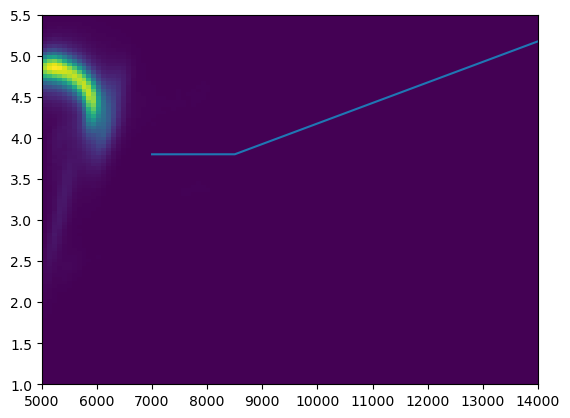

In [31]:
plt.hist2d(tab_comb['TEFF'].filled(np.nan), tab_comb['LOGG'].filled(np.nan),
           range=[[5000,14000],[1,5.5]],bins=[100,100]);
xgrid = np.linspace(7000, 17000, 1000)
plt.plot(xgrid, 3.8 + np.maximum(xgrid - 8500,0)*0.00025)

In [32]:
good =  (tab_comb['RVS_WARN']==0)

tab_comb['GOOD_STAR'] = good & (tab_comb['RR_SPECTYPE']=='STAR')

In [33]:
T=tab_comb

(array([ 174223.,  953271., 1013376.,  884707.,  750159.,  573881.,
         444613.,  415688.,  384651.,  200812.]),
 array([-19.55122639,  -9.67028978,   0.21064683,  10.09158344,
         19.97252006,  29.85345667,  39.73439328,  49.6153299 ,
         59.49626651,  69.37720312,  79.25813973]),
 <BarContainer object of 10 artists>)

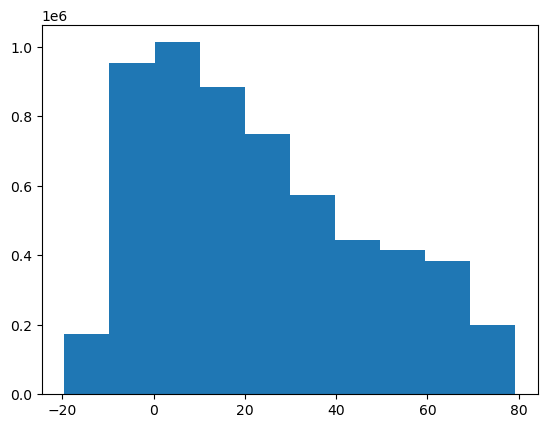

In [34]:
blehind =  T['IN_MWS']

plt.hist(T['DEC'][blehind])

In [35]:
#len(xind1), len(xind2)

/tmp/ipykernel_1111849/2169052841.py:13: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((hh2/hh1).T


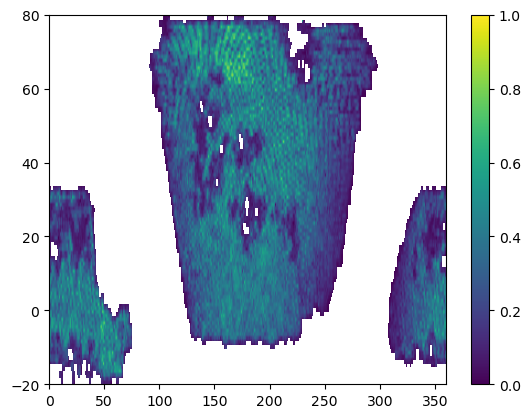

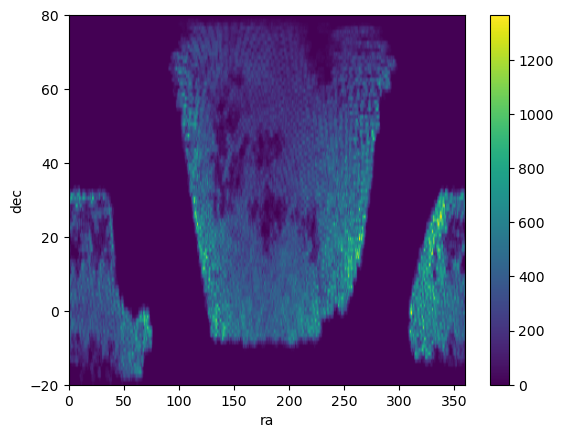

In [36]:
xind1 = T['IN_FOOT']
xind2 = T['IN_FOOT'] & T['IN_MWS']


ranges = [[0,360],[-20,80]]
#ranges = [[0,360],[-80,80]]

bins = [360,100]

hh1, xloc, yloc = np.histogram2d(T['RA'][xind1],T['DEC'][xind1],range=ranges,bins=bins)
hh2, _, _ = np.histogram2d(T['RA'][xind2],T['DEC'][xind2],range=ranges,bins=bins)

plt.imshow((hh2/hh1).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
                    aspect='auto')
plt.colorbar()

plt.show()


plt.imshow((hh2).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
                    aspect='auto')
plt.xlabel("ra")
plt.ylabel('dec')

plt.colorbar()




/tmp/ipykernel_1111849/3962430927.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((hh2/hh1), aspect='auto')


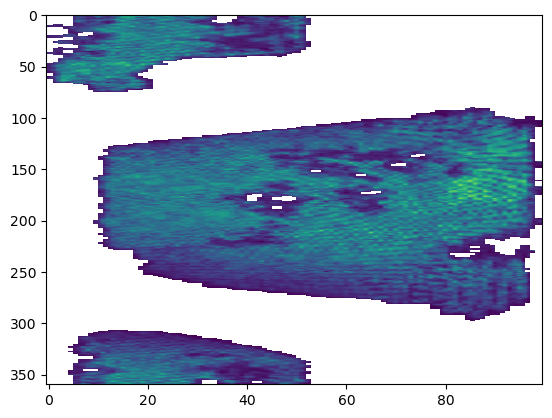

In [37]:
plt.imshow((hh2/hh1), aspect='auto')


In [38]:
T['completeness'] = np.nan

In [39]:
# same as xloc and yloc
raxxx = np.arange(0, 361.)
decyyy = np.arange(-20, 81.)


In [40]:
ratio_2darr = (hh2/hh1) # rows are ra and columns are dec
np.shape(ratio_2darr)

/tmp/ipykernel_1111849/3102878933.py:1: RuntimeWarning: invalid value encountered in true_divide
  ratio_2darr = (hh2/hh1) # rows are ra and columns are dec


(360, 100)

In [41]:
from astropy.io import fits

In [42]:
hdu = fits.PrimaryHDU(ratio_2darr)
hdu.writeto('/global/u2/m/mlambert/UCSC_DESI_MW/completeness_2d_loa.fits')

# above is the file that we use to make the completeness

In [35]:
print(np.shape(hh2), len(xloc), len(yloc))


# for star in a certain bin
# assign a completeness number to it
# save the number as a column
# the column should match the in_mws column number

inmws_ind = T['IN_MWS']

for i in range(len(xloc)-1):
    for j in range(len(yloc)-1):
        radecindex = np.where((T['RA'][inmws_ind] > xloc[i]) & (T['RA'][inmws_ind] < (xloc[i]+1)) & (T['DEC'][inmws_ind] > yloc[j]) & (T['DEC'][inmws_ind] < (yloc[j]+1)))
        #print(len(radecindex[0]), hh2[i][j])
        
        
        #print(T['TARGETID'][radecindex]) # grab the target id for each star in the bin
        
        #inmws_index = np.where(T['TARGETID'][radecindex]==tab_mws['TARGETID'])
        #print(inmws_index)
        #print(tab_mws['TARGETID'][inmws_index])
        #print()
        
        ## make sure these are the target ids only in inmws
        ## we want the rows to match the inmws bc that is what we use in the other notebook
        
        ## what is the completeness factor for this bin?
        #print(hh2[i][j]/hh1[i][j])
        
        completeness = hh2[i][j]/hh1[i][j]
        comp_ratio = 1/completeness
        #print(comp_ratio)
        
        T['completeness'][radecindex] = completeness
        
        
        if i % 1==0:
            if j % 10 == 0:
                print(i, j)
                                        
        #T['TARGET_ID']
        

(180, 50) 181 51


/tmp/ipykernel_206192/1441327466.py:29: RuntimeWarning: invalid value encountered in double_scalars
  completeness = hh2[i][j]/hh1[i][j]


0 0
0 10
0 20
0 30
0 40
1 0
1 10


/tmp/ipykernel_206192/1441327466.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  comp_ratio = 1/completeness


1 20
1 30
1 40
2 0
2 10
2 20
2 30
2 40
3 0
3 10
3 20
3 30
3 40
4 0
4 10
4 20
4 30
4 40
5 0
5 10
5 20
5 30
5 40
6 0
6 10
6 20
6 30
6 40
7 0
7 10
7 20
7 30
7 40
8 0
8 10
8 20
8 30
8 40
9 0
9 10
9 20
9 30
9 40
10 0
10 10
10 20
10 30
10 40
11 0
11 10
11 20
11 30
11 40
12 0
12 10
12 20
12 30
12 40
13 0
13 10
13 20
13 30
13 40
14 0
14 10
14 20
14 30
14 40
15 0
15 10
15 20
15 30
15 40
16 0
16 10
16 20
16 30
16 40
17 0
17 10
17 20
17 30
17 40
18 0
18 10
18 20
18 30
18 40
19 0
19 10
19 20
19 30
19 40
20 0
20 10
20 20
20 30
20 40
21 0
21 10
21 20
21 30
21 40
22 0
22 10
22 20
22 30
22 40
23 0
23 10
23 20
23 30
23 40
24 0
24 10
24 20
24 30
24 40
25 0
25 10
25 20
25 30
25 40
26 0
26 10
26 20
26 30
26 40
27 0
27 10
27 20
27 30
27 40
28 0
28 10
28 20
28 30
28 40
29 0
29 10
29 20
29 30
29 40
30 0
30 10
30 20
30 30
30 40
31 0
31 10
31 20
31 30
31 40
32 0
32 10
32 20
32 30
32 40
33 0
33 10
33 20
33 30
33 40
34 0
34 10
34 20
34 30
34 40
35 0
35 10
35 20
35 30
35 40
36 0
36 10
36 20
36 30
36 40
37 0
37 10

In [40]:
len(tab_mws), len(T['completeness'][np.where(np.isnan(T['completeness'])==False)])

(7351758, 1453829)

In [61]:
len(np.where(T['IN_MWS']==True)[0]), len(T['IN_MWS'])


(5796785, 37677141)

In [51]:
t_comp = atpy.Table()
t_comp['TARGETID'] = T['TARGETID']
t_comp['completeness'] = T['completeness']

In [55]:
pwd

'/global/u2/m/mlambert/UCSC_DESI_MW'

In [56]:
#t_comp.write('/global/u2/m/mlambert/UCSC_DESI_MW/completeness_test.fits')  

In [72]:
intersect, indices1, indices2 = np.intersect1d(t_comp['TARGETID'],tab_mws['TARGETID'], return_indices=True)

In [82]:
len(tab_mws['TARGETID']), len(t_comp['TARGETID']), len(indices1)

(7351758, 37677141, 5796785)

In [81]:
t_comp['TARGETID'][indices1]

39627322701124267
39627322701128906
39627322705314528
39627322940194980
39627322940198003
39627322940199094
39627322940200520
39627322944394358
39627322944397016
39627322948585672
39627322948586385


In [78]:
# not all the targets in rvmws are in the target_table

/tmp/ipykernel_1765291/4278738582.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((hh2/hh1).T


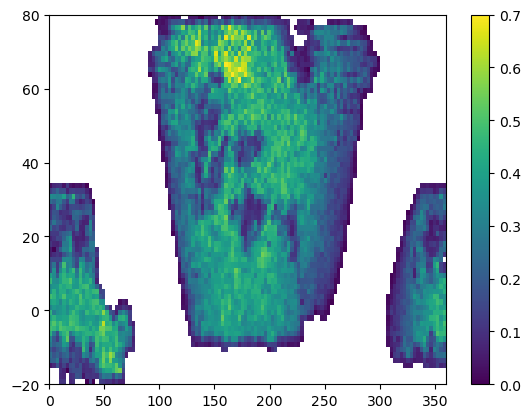

In [52]:
plt.imshow((hh2/hh1).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
           vmax = 0.7,
                    aspect='auto')
plt.colorbar()

In [53]:
#COV_HPX, COVCNT = np.array(list(cov_dict.items())).T
#atpy.Table({'healpix':COV_HPX, 'npass':COVCNT}).write('coverage.fits',
#                                                      overwrite=True)

/tmp/ipykernel_1765291/879080179.py:16: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((hh2/hh1).T


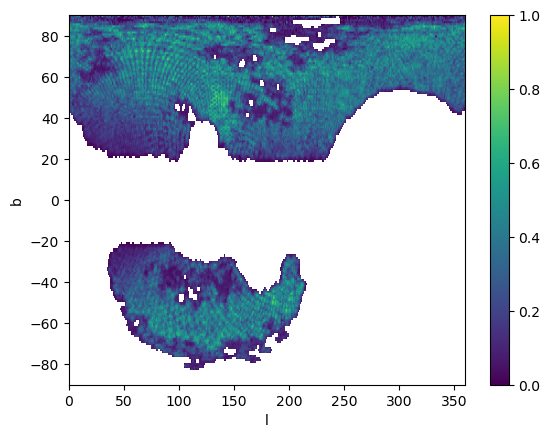

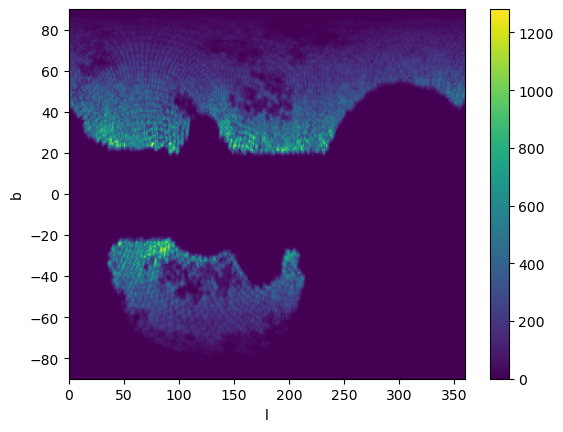

In [60]:
# transform ra and dec to l and b

XC = acoo.SkyCoord(tab_comb['RA'], tab_comb['DEC'],
                 unit=['deg',
                       'deg']).transform_to(acoo.Galactic)
l, b = XC.l.deg, XC.b.deg
#tab_comb['L'] = l
#tab_comb['B'] = b
ranges = [[0,360],[-90,90]]
#ranges = [[0,360],[-80,80]]

bins = [360, 180]
hh1, xloc, yloc = np.histogram2d(l[xind1],b[xind1],range=ranges,bins=bins)
hh2, _, _ = np.histogram2d(l[xind2],b[xind2],range=ranges,bins=bins)

plt.imshow((hh2/hh1).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
                    aspect='auto')
plt.xlabel("l")
plt.ylabel('b')

plt.colorbar()
plt.show()

plt.imshow((hh2).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
                    aspect='auto')
plt.xlabel("l")
plt.ylabel('b')

plt.colorbar()

/tmp/ipykernel_1765291/2755150574.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((hh2/hh1).T


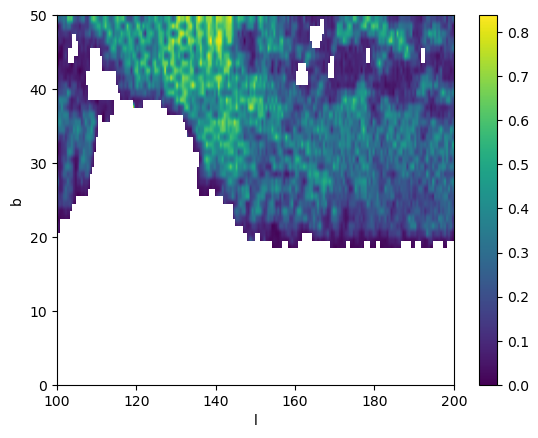

In [58]:
ranges = [[100,200],[0,50]]
#ranges = [[0,360],[-80,80]]


bins = [200, 50]
hh1, xloc, yloc = np.histogram2d(l[xind1],b[xind1],range=ranges,bins=bins)
hh2, _, _ = np.histogram2d(l[xind2],b[xind2],range=ranges,bins=bins)

plt.imshow((hh2/hh1).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
                    aspect='auto')
plt.xlabel("l")
plt.ylabel('b')

plt.colorbar()

In [56]:
(hh2/hh1)

/tmp/ipykernel_1765291/4259085415.py:1: RuntimeWarning: invalid value encountered in true_divide
  (hh2/hh1)


array([[       nan,        nan,        nan, ..., 0.13559322, 0.0326087 ,
        0.3761194 ],
       [       nan,        nan,        nan, ..., 0.10280374, 0.11182109,
        0.26153846],
       [       nan,        nan,        nan, ..., 0.11369509, 0.18844985,
        0.296875  ],
       ...,
       [       nan,        nan,        nan, ..., 0.19444444, 0.2437276 ,
        0.20833333],
       [       nan,        nan,        nan, ..., 0.12075472, 0.16666667,
        0.16363636],
       [       nan,        nan,        nan, ..., 0.09965636, 0.06164384,
        0.25498008]])

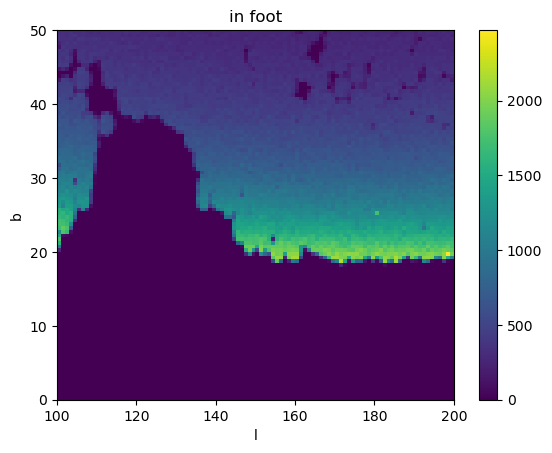

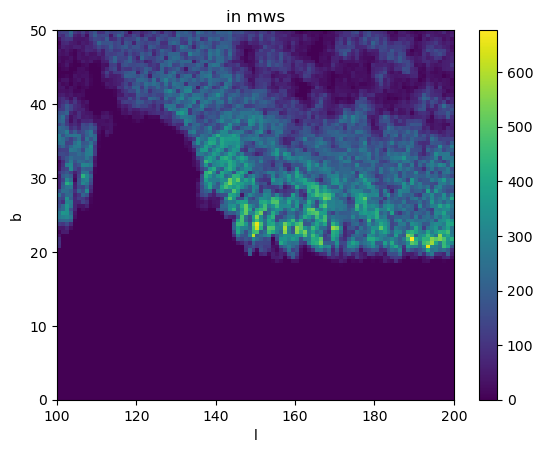

In [57]:
ranges = [[100,200],[0,50]]
#ranges = [[0,360],[-80,80]]

bins = [100, 100]
hh1, xloc, yloc = np.histogram2d(l[xind1],b[xind1],range=ranges,bins=bins)
hh2, _, _ = np.histogram2d(l[xind2],b[xind2],range=ranges,bins=bins)

plt.imshow((hh1).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
                    aspect='auto')
plt.xlabel("l")
plt.ylabel('b')
plt.title('in foot')

plt.colorbar()
plt.show()


plt.imshow((hh2).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
                    aspect='auto')
plt.xlabel("l")
plt.ylabel('b')
plt.title('in mws')

plt.colorbar()
plt.show()

In [ ]:
pwd

In [ ]:
len(tab_intargets), len(tab_mws), len(tab_mws_gaia), len(tab_mws_dist)


In [ ]:
aa = np.array([1,2,3,4,5,6,7,8])
bb = np.array([1,2,3,np.nan, np.nan])

masky = np.in1d(aa,bb)
aa[masky]

In [ ]:
aa = np.array(tab_intargets['TARGETID'])
bb = np.array(tab_mws_dist['TARGETID'])

mask_mws = np.in1d(bb, aa)
print(len(mask_mws))

masky_intargets = np.in1d(aa, bb)
print(len(masky_intargets))


In [ ]:
len(tab_mws_dist[mask_mws]), len(tab_intargets[masky_intargets]), len(tab_mws_dist), len(tab_intargets)

In [ ]:
# instead pull a np.where 9target id in mws is in tab_intagerts)

#intarget_mws_index = np.where(tab_intargets['TARGETID'][masky_intargets] == tab_mws_dist['TARGETID'][mask_mws])
#intarget_mws_index_gaia = np.where(tab_intargets['RA']==tab_mws_gaia['RA'])
#intarget_mws_index=[np.where(tab_intargets['TARGETID'][masky_intargets] == i) for i in tab_mws_dist['TARGETID'][mask_mws]]

around_x = set(tab_mws_dist['TARGETID'][mask_mws])
index_bigx = [i for i,b in enumerate(tab_intargets['TARGETID'][masky_intargets]) if b in around_x]

In [ ]:
infoot = tab_intargets['IN_FOOT'][masky_intargets]

inmws = tab_intargets['IN_MWS'][masky_intargets]

In [ ]:
plt.hist(((tab_intargets['IN_FOOT'] & tab_intargets['IN_MWS']) / tab_intargets['IN_FOOT']), bins=50)
plt.yscale('log')
plt.show()

In [ ]:
tab_intargets_masked = tab_intargets[masky_intargets]

# Kiel diagram of all

In [ ]:
plt.hist2d(tab_mws['TEFF'], tab_mws['LOGG'],
           range=[[2500,7000],[1,5.5]],bins=[100,100]);
#xgrid = np.linspace(7000, 17000, 1000)
#plt.plot(xgrid, 3.8 + np.maximum(xgrid - 8500,0)*0.00025)

# Define the extinction corrected colours

In [ ]:
tab_mws = tab_mws[mask_mws]
tab_mws_gaia = tab_mws_gaia[mask_mws]
tab_mws_dist = tab_mws_dist[mask_mws]

In [ ]:
len(tab_mws)

In [ ]:

col,mag=(-2.5 * np.log10(tab_intargets_masked['FLUX_G']/tab_intargets_masked["FLUX_R"]/
                         tab_intargets_masked['MW_TRANSMISSION_G']*tab_intargets_masked['MW_TRANSMISSION_R']),
        22.5 - 2.5 * np.log10(tab_intargets_masked['FLUX_R']/tab_intargets_masked['MW_TRANSMISSION_R']))

idxp3,=np.where((mag < 25.0) & # originally 19
                (tab_mws['RVS_WARN'] == 0) &
                (tab_mws['RR_SPECTYPE'] == 'STAR')&
                (tab_mws['SN_R'] > 5)
                )
              
print(len(idxp3))

apply cuts to the table


In [ ]:
len(infoot), len(tab_mws), len(tab_mws_gaia), len(tab_mws_dist)

In [ ]:
ra = np.array(tab_mws['TARGET_RA'][idxp3])
dec = np.array(tab_mws['TARGET_DEC'][idxp3])
#feh = np.array(rvtab_y3['FEH'][idxp3])
#alphafe = np.array(rvtab_y3['ALPHAFE'][idxp3])
teff = np.array(tab_mws['TEFF'][idxp3])
vrad = np.array(tab_mws['VRAD'][idxp3]) # km/s
snr = np.array(tab_mws['SN_R'][idxp3])
logg = np.array(tab_mws['LOGG'][idxp3])

pmra = np.array(tab_mws_gaia['PMRA'][idxp3]) # milli arcsec /yr
pmdec = np.array(tab_mws_gaia['PMDEC'][idxp3])
#parallax = np.array(gaiatab_y3["PARALLAX"][idxp3])
#parallax_error = np.array(gaiatab_y3["PARALLAX_ERROR"][idxp3])


dist = (1/1000)*10**((np.array(tab_mws_dist['dist_mod'][idxp3]))/5 +1) # in kpc now


gmr = col[idxp3]
rmag = mag[idxp3]


infoot_mws = infoot[idxp3]
inmws_mws = inmws[idxp3]


In [ ]:
def phase_spiral_values(dist, ra, dec, pmra, pmdec, vrad, dist_min=0, dist_max=50):
    '''
    converts ra and dec coords to r,phi,z galactic coords
    inputs: 
            dist: distance object is from us in kpc
            ra: ra
            dec: dec
            pmra: ra proper motion 
            pmdec: dec proper motion
            vrad: line of sight velocity
            
            dist_min: min distance range
            dist_max: max distance range to be calulcat
    
    outputs: r,phi,z, and their respective velocities
    '''
    
    dist_index = np.where((dist<=dist_max) & (dist>dist_min))
    dist_cut = dist[dist_index]
    ra_cut = ra[dist_index]
    dec_cut = dec[dist_index]
    pmra_cut = pmra[dist_index]
    pmdec_cut = pmdec[dist_index]
    vrad_cut = vrad[dist_index]
    
    
    c= coord.ICRS(ra=ra_cut*u.deg,
              dec=dec_cut*u.deg,
                  distance=dist_cut*u.kpc,
                  pm_ra_cosdec=pmra_cut*u.mas/u.yr,
                  pm_dec=pmdec_cut*u.mas/u.yr,
                  radial_velocity=vrad_cut*u.km/u.s)
    
    # Define GC frame
    v_sun = coord.CartesianDifferential([11.1,248.5,7.25]*u.km/u.s) #Schönrich et al. 2010; Reid & Brunthaler 2020),
    gc_frame= coord.Galactocentric(galcen_distance=8.178*u.kpc, # gravity collab 2019
                                       z_sun=20.8*u.pc, # Bennett & Bovy 2019).
                                       galcen_v_sun=v_sun)
    cg= c.transform_to(gc_frame)

    cg.representation_type = 'cylindrical'
    
    r = cg.rho.to(u.kpc).value
    phi = cg.phi.degree
    z = cg.z.to(u.kpc).value
    v_r = cg.d_rho.to(u.km/u.s).value
    v_phi = (cg.d_phi*cg.rho).to(u.km/u.s,
            equivalencies=u.dimensionless_angles()).value
    v_z = cg.d_z.to(u.km/u.s).value
    
    
    return r, phi, z, v_r, v_phi, v_z


In [ ]:
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy.coordinates import ICRS, Galactic
from astropy.table import Table, hstack, vstack
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [ ]:
temp_ra = ra
temp_dec = dec
temp_dist = dist


max_dist = 50

objall = coord.SkyCoord(ra=temp_ra[np.where(temp_dist < max_dist)] * u.degree,
                   dec=temp_dec[np.where(temp_dist < max_dist)] * u.degree,
                   distance= temp_dist[np.where(temp_dist < max_dist)] * u.kpc,
                   frame='icrs')
objall = objall.transform_to(coord.Galactocentric)


galac_x = -objall.x.value
galac_y = objall.y.value

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra,
                                                 dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad,
                                                 dist_max = max_dist, dist_min=0)


dist_index = np.where((dist<=max_dist) & (dist>0))

obj1 = SkyCoord(temp_ra[np.where(temp_dist < max_dist)],
                temp_dec[np.where(temp_dist < max_dist)],frame='icrs', unit=u.deg)            
obj1 = obj1.galactic

l_tot = obj1.l.degree
b_tot = obj1.b.degree


# only looking at outer regions
neg_phi_index = np.where(phi <0)
phi[neg_phi_index] = phi[neg_phi_index]+360


ind500 = np.where((np.abs(z)<10)&
                  (phi>160)&(phi<200)&
                  (r>7)&
                  #(b_tot> 35)&(b_tot < 40)&
                  (v_phi<np.nanpercentile(v_phi, 80))&(v_phi>np.nanpercentile(v_phi, 1)))

In [ ]:
len(ra), len(infoot_mws)

In [ ]:
raind500 = ra[ind500]

decind500 = dec[ind500]

In [ ]:
xind1 = infoot_mws[ind500]
xind2 = infoot_mws[ind500] & inmws_mws[ind500] 
hh1, xloc, yloc = np.histogram2d(raind500[xind1],decind500[xind1],range=[[0,360],[-20,80]],bins=[200,100])
hh2, _, _ = np.histogram2d(raind500[xind2],decind500[xind2],range=[[0,360],[-20,80]],bins=[200,100])

plt.imshow((hh2/hh1).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
                    aspect='auto', vmax=.7)
plt.colorbar()

so maybe this is all saying that the stars selected are in the footprint and the mws


the issue is the masking

the way the mask is set up is that i am row matching to the smaller table, when really I should be matching to
the larger array, filling the smaller array in with nans??

In [ ]:
xind1 = infoot_mws
xind2 = infoot_mws & inmws_mws

bins=[10,10]
hh1,xloc,yloc = np.histogram2d(gmr[xind1],rmag[xind1],
                               range=[[-.35,0],[16,20]],bins=bins)
hh2 = np.histogram2d(gmr[xind2],rmag[xind2],
                     range=[[-.35,0],[16,20]],bins=bins)[0]
plt.imshow((hh2/hh1).T
           ,origin='upper',
           extent=[xloc[0],xloc[-1],yloc[-1],yloc[0]],
           aspect='auto',vmax=1,vmin=.1,cmap='turbo')
plt.xlabel('g-r [mag]')
plt.ylabel('r [mag]')
plt.title('Fraction of stars that ends up in the RVS catalogue') 
plt.colorbar()

In [ ]:
COV_HPX, COVCNT = np.array(list(cov_dict.items())).T
atpy.Table({'healpix':COV_HPX, 'npass':COVCNT}).write('coverage.fits',
                                                      overwrite=True)

In [ ]:
cov_nside

In [ ]:
import sys
sys.path.append('/global/homes/k/koposov/astrolibpy/plotting')
sys.path.append('/global/homes/k/koposov/astrolibpy/my_utils')

In [ ]:
from idlplotInd import tvhist2d, plothist

In [ ]:
xhpx = healpy.ang2pix(cov_nside,
                      tab_comb['RA'],
                      tab_comb["DEC"], 
                      lonlat=True,
                      nest=True)
npass = np.array([cov_dict.get(_) or 0 for _ in xhpx])
tab_comb['npass'] = npass

covert to cylidrical galactocentric coords

create wedge cut

apply wedge cut to

footprint number pass values

# colour magnitude distribution of all input targets

In [ ]:
plt.hist2d(col[T['IN_FOOT']], mag[T['IN_FOOT']],bins=[40,40]);
plt.ylim(*plt.ylim()[::-1])
plt.xlabel('g-r')
plt.ylabel('r')

In [ ]:
# Check 1

# Number of stars in RVS is and redshift catalog is very similar 

# I am expecting the cause is either option 4 or 5 in the list
# Since numbers are close, IMO this can be ignored 
print (T['IN_MWS'].sum(), T['IN_ZCAT'].sum())

# The incompleteness as a function of colour magnitude of being observed

The reason why there is an excess below 19 is due to secondary BHBs or because 
some stars were targeted as something else (TO check). 
But otherwise is incompleteness is pretty uniform

In [ ]:
xind1 = T['IN_FOOT'] 
xind2 = T['IN_FOOT'] & T['IN_MWS'] 
bins=[10,10]
hh1,xloc,yloc = np.histogram2d(col[xind1],mag[xind1],
                               range=[[-.35,0],[16,20]],bins=bins)
hh2 = np.histogram2d(col[xind2],mag[xind2],
                     range=[[-.35,0],[16,20]],bins=bins)[0]
plt.imshow((hh2/hh1).T
           ,origin='upper',
           extent=[xloc[0],xloc[-1],yloc[-1],yloc[0]],
           aspect='auto',vmax=.5,vmin=.1,cmap='turbo')
plt.xlabel('g-r [mag]')
plt.ylabel('r [mag]')
plt.title('Fraction of stars that ends up in the RVS cat0alogue') 
plt.colorbar()

In [ ]:
xind1 = T['IN_FOOT'] & T['IN_MWS']
xind2 = T['IN_FOOT'] & T['OTHER_STAR']
bins=[10,10]
hh1,xloc,yloc = np.histogram2d(col[xind1],mag[xind1],
                               range=[[-.35,0],[16,20]],bins=bins)
hh2 = np.histogram2d(col[xind2],mag[xind2],
                     range=[[-.35,0],[16,20]],bins=bins)[0]
plt.imshow((hh2/hh1).T
           ,origin='upper',
           extent=[xloc[0],xloc[-1],yloc[-1],yloc[0]],
           aspect='auto',vmax=.5,vmin=.1,cmap='turbo')
plt.xlabel('g-r [mag]')
plt.ylabel('r [mag]')
plt.title('Fraction of stars that are classified as other star') 
plt.colorbar()

# fraction of objects that are not stars 

In [ ]:
xind1 = T['IN_FOOT'] & T['IN_MWS']
xind2 = T['IN_FOOT'] & T['NOT_STAR']
bins=[10,10]
hh1,xloc,yloc = np.histogram2d(col[xind1],mag[xind1],
                               range=[[-.35,0],[16,20]],bins=bins)
hh2 = np.histogram2d(col[xind2],mag[xind2],
                     range=[[-.35,0],[16,20]],bins=bins)[0]
plt.imshow((hh2/hh1).T
           ,origin='upper',
           extent=[xloc[0],xloc[-1],yloc[-1],yloc[0]],
           aspect='auto',vmax=.9,vmin=.1,cmap='turbo')
plt.xlabel('g-r [mag]')
plt.ylabel('r [mag]')
plt.title('Fraction of stars that are classified as not star') 
plt.colorbar()

# fraction of target hitting edges of parameter grid  or having large velocity error 

The explanation of the plot -- stars that are hotter than 15k. 
TBC if those are real BHB -- most likely not .

In [ ]:
xind1 = T['IN_FOOT'] & T['IN_MWS']
xind2 = T['IN_FOOT'] & ((T['RVS_WARN']&(4+8))>0)
bins=[10,10]
hh1,xloc,yloc = np.histogram2d(col[xind1],mag[xind1],
                               range=[[-.35,0],[16,20]],bins=bins)
hh2 = np.histogram2d(col[xind2],mag[xind2],
                     range=[[-.35,0],[16,20]],bins=bins)[0]
plt.imshow((hh2/hh1).T
           ,origin='upper',
           extent=[xloc[0],xloc[-1],yloc[-1],yloc[0]],
           aspect='auto',vmax=.9,vmin=.1,cmap='turbo')
plt.xlabel('g-r [mag]')
plt.ylabel('r [mag]')
plt.title('Fraction of stars that are classified as other star') 
plt.colorbar()

# Spatial completeness

Fraction of objects observed as a function of position on the sky

In [ ]:
xind1 = T['IN_FOOT'] 
xind2 = T['IN_FOOT'] & T['IN_MWS'] 
hh1, xloc, yloc = np.histogram2d(T['RA'][xind1],T['DEC'][xind1],range=[[0,360],[-20,80]],bins=[120,70])
hh2, _, _ = np.histogram2d(T['RA'][xind2],T['DEC'][xind2],range=[[0,360],[-20,80]],bins=[120,70])

plt.imshow((hh2/hh1).T
           ,origin='lower',
           extent=[xloc[0], xloc[-1],
                   yloc[0], yloc[-1]],
                    aspect='auto', vmax=.7)
plt.colorbar()

Write a table with healpix  and number of passes

In [ ]:
COV_HPX, COVCNT = np.array(list(cov_dict.items())).T
atpy.Table({'healpix':COV_HPX, 'npass':COVCNT}).write('coverage.fits',
                                                      overwrite=True)

In [ ]:
XC = acoo.SkyCoord(tab_comb['RA'], tab_comb['DEC'],
                 unit=['deg',
                       'deg']).transform_to(acoo.Galactic)
l, b = XC.l.deg, XC.b.deg
tab_comb['L'] = l
tab_comb['B'] = b

In [ ]:
xhpx = healpy.ang2pix(cov_nside,
                      tab_comb['RA'],
                      tab_comb["DEC"], 
                      lonlat=True,
                      nest=True)
npass = np.array([cov_dict.get(_) or 0 for _ in xhpx])
tab_comb['npass'] = npass

In [ ]:
tab_comb.write('bhb_sel_func_file.fits', overwrite=True)

In [ ]:
tab_comb

In [ ]:
xra, xdec = healpy.pix2ang(cov_nside, COV_HPX, lonlat=True, nest=True)

# Number of passes as a function of position

Next section relies on some additional plotting routines


In [ ]:
import sys
sys.path.append('/global/homes/k/koposov/astrolibpy/plotting')
sys.path.append('/global/homes/k/koposov/astrolibpy/my_utils')

In [ ]:
from idlplotInd import tvhist2d, plothist

In [ ]:
tvhist2d(xra, xdec, 360, 0, -20, 90, weights=COVCNT, cmap='turbo', weight_norm=True,
         bar=True, vmin=0,bins=[360*3, 110*3
                               ]);

# Fraction of objects observed as a function of number of passes

In [ ]:
plothist(npass, ind =tab_comb['IN_FOOT'], weights= (tab_comb['IN_MWS']).astype(int),
        weight_norm=True, bin=1,min=-.5,max=5.5,yr=[0,1],
        xtitle='Npass',ytitle='Fraction')

In [ ]:
for i in range(1,5):
    plt.subplot(2,2,i)
    plothist(np.abs(b), ind=tab_comb['IN_FOOT'] & (npass==i), 
            weights=tab_comb['IN_MWS'].astype(int),
            weight_norm=True, bin=20,
            min=0, max=90, yr=[0,1],
            noerase=True,title='NPASS=%d'%i,
            xtitle='galactic latitude')
plt.tight_layout()